In [1]:
from utils import save_submission,load_data
import numpy as np
import copy
import matplotlib.pylab as plt
%matplotlib inline
CLASSES = 10 # note: could have inferred this automatically from the labels

In [56]:
def softmax(Z):
    """
    Convert a set of scores from a linear model into a softmax posterior
    Input:
    Z: N x C array of scores
        Z[n][:] is the set of scores for C classes for the n-th example
    Output:
    S: N x C array
        S[n][:] is the softmax distribution over C classes for the n-th example
    """
    
    S = np.exp(Z)
    norm = np.sum(S,1)
    norm = norm[:, np.newaxis]
    return S/norm

def predict(X, model):
    """
    Evaluate the soft predictions of the model.
    Input:
    X : N x d array (no unit terms)
    model : dictionary containing 'weight' and 'bias'
    Output:
    yhat : N x C array
        yhat[n][:] contains the softmax posterior distribution over C classes for X[n][:]
    """
    return softmax(np.dot(X, model['weight']) + model['bias'])

def test(X, Y, model):
    """
    Compute hard label assignments based on model predictions, and return the accuracy vector
    Input:
    X : N x d array of data (no constant term)
    Y : N x C array with 1-hot encoding of true labels
    model: dictionary 
    Output:
    acc : N array of errors, acc[n] is 1 if correct and 0 otherwise
    """
    return predict(X, model).argmax(-1) == Y.argmax(-1)

def error_rate(X, Y, model):
    """
    Compute error rate (between 0 and 1) for the model
    """
    return 1 - test(X, Y, model).mean()

def calc_loss(X, Y, model):
    """
    Evaluate the loss (without regularization penalty), i.e., normalized negative log likelihood
    """
    Z = predict(X, model)
    return -(Y * np.log(Z)).sum() / len(Y)

In [90]:
def calcGrad(X, Y, model):
    """
    Calculate the gradient of the loss w.r.t. model parameters
    Output:
    grad_W : same dimension as model['weight']; gradient w.r.t. the weights
    grad_b : same dimension as model['bias']; gradient w.r.t. the bias terms
    """
    N = float(len(X))
    pred = Y-predict(X,model)
    grad_W = -1/N*(np.dot(X.transpose(),pred))
    grad_b = -1/N*(np.sum(pred,0))
    return grad_W, grad_b

def modelUpdate(X, Y, model, lambda_, eta):
    """
    Update the model
    Input:
    X, Y : the inputs and 1-hot encoded labels
    model : the currrent model
    lambda : regularization coefficient for L2 penalty
    eta : learning rate
    Output:
    updated model
    """
    grad_W,grad_b = calcGrad(X,Y,model)
    
    model['weight'] -= eta*(grad_W +lambda_*model['weight'])
    model['bias'] -= eta*grad_b
    return model

In [50]:
def runTrainVal(X,Y,model,Xval,Yval,trainopt):
    """
    Run the train + evaluation on a given train/val partition
    trainopt: various (hyper)parameters of the training procedure
    """
    
    eta = trainopt['eta']
    
    N = X.shape[0] # number of data points in X
    
    shuffled_idx = np.random.permutation(N)
    start_idx = 0
    for iteration in range(trainopt['maxiter']):
        if iteration % int(trainopt['eta_frac'] * trainopt['maxiter']) == 0:
            eta *= trainopt['etadrop']
        # form the next mini-batch
        stop_idx = min(start_idx + trainopt['batch_size'], N)
        batch_idx = range(N)[int(start_idx):int(stop_idx)]
        bX = X[shuffled_idx[batch_idx],:]
        bY = Y[shuffled_idx[batch_idx],:]
        if (iteration % trainopt['display_iter']) == 0:
            print('{:8} batch loss: {:.3f}'.format(iteration, calc_loss(bX, bY, model)))
        model = modelUpdate(bX, bY, model, trainopt['lambda'], eta)
        start_idx = stop_idx % N
        
    # compute train and val error; multiply by 100 for readability (make it percentage points)
    trainError = 100 * error_rate(X, Y, model)
    valError = 100 * error_rate(Xval, Yval, model)
    
    return model,valError,trainError

In [51]:
data_fn = "NOISY_MNIST_SUBSETS.h5"

print("Load small train.")
Xsmall,Ysmall = load_data(data_fn, "small_train")
print(Xsmall.shape)
print(Ysmall.shape)

print("Load large train.")
Xlarge,Ylarge = load_data(data_fn, "large_train")
print(Xlarge.shape)
print(Ylarge.shape)

print("Load val.")
Xval,Yval = load_data(data_fn, "val")
print(Xval.shape)
print(Yval.shape)

Load small train.
(400L, 576L)
(400L, 10L)
Load large train.
(8000L, 576L)
(8000L, 10L)
Load val.
(2000L, 576L)
(2000L, 10L)


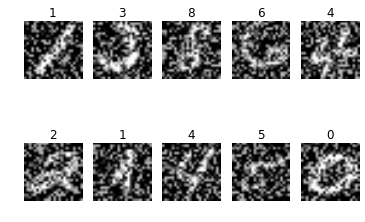

In [52]:
# -- display first ten small train examples
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(Xsmall[i,:].reshape(24,24),cmap='gray')
    plt.title(repr(Ysmall[i].argmax(-1)))
    plt.axis('off')

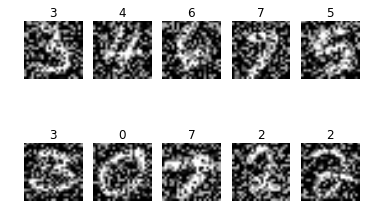

In [53]:
# -- display first ten val examples
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(Xval[i,:].reshape(24,24),cmap='gray')
    plt.title(repr(Yval[i].argmax(-1)))
    plt.axis('off')

In [80]:
# -- training options; these are suggestions, feel free to experiment
trainopt = {
    'eta': 1,   # initial learning rate
    'maxiter': 100000,   # max number of iterations (updates) of SGD
    'display_iter': 20000,  # display batch loss every display_iter updates
    'batch_size': 10,  
    'etadrop': .5, # when dropping eta, multiply it by this number (e.g., .5 means halve it)
    'eta_frac': .2  # drop eta every eta_frac fraction of the max iterations
                    # so if eta_frac is .2, and maxiter is 10000, drop eta every 2000 iterations
}

NFEATURES = Xsmall.shape[1]

seed = np.random.RandomState(2341)  # to make sure everyone starts from the same point
random_init = seed.normal(scale=0.01, size=(NFEATURES,CLASSES)) # -- with random seed fixed

model = { 'weight': random_init, 'bias': np.zeros(CLASSES) }

# set the (initial?) set of lambda values to explore
lambdas = np.array([0.05,0.001,0.01,0.005])

# we will maintain a record of models trained for different values of lambda
# these will be indexed directly by lambda value itself
small_trained_models = dict()
large_trained_models = dict()

# -- small train set: sweep the lambda values
for lambda_ in lambdas:
    trainopt['lambda'] = lambda_
    # -- model trained on small train set
    # note: you need deepcopy here because of the way Python handles copying of complex objects like dictionaries
    # by default, it would copy it by reference, i.e., it would make a new pointer to the same data, so later changing
    # the contents would change the "copied" version as well. deepcopy actually makes a copy.
    trained_model,valErr,trainErr = runTrainVal(Xsmall, Ysmall, copy.deepcopy(model), Xval, Yval, trainopt)
    small_trained_models[lambda_] = {'model': trained_model, "val_err": valErr, "train_err": trainErr }
    print('small train set model: -> lambda= %.4f, train error: %.2f, val error: %.2f' % (lambda_, trainErr, valErr))
    
    
for lambda_ in lambdas:
    trainopt['lambda'] = lambda_
    # -- model trained on large train set
    trained_model,valErr,trainErr = runTrainVal(Xlarge, Ylarge, copy.deepcopy(model), Xval, Yval, trainopt)
    large_trained_models[lambda_] = {'model': trained_model, "val_err": valErr, "train_err": trainErr }
    print('large train set model: -> lambda= %.4f, train error: %.2f, val error: %.2f' % (lambda_, trainErr, valErr))
    
best_small_trained_lambda = 0.
best_small_trained_model = None
best_small_trained_val_err = 100.
for lambda_,results in small_trained_models.items():
    if results['val_err'] < best_small_trained_val_err:
        best_small_trained_val_err = results['val_err']
        best_small_trained_model = results['model']
        best_small_trained_lambda = lambda_
        
best_large_trained_lambda = 0.
best_large_trained_model = None
best_large_trained_val_err = 100.
for lambda_,results in large_trained_models.items():
    if results['val_err'] < best_large_trained_val_err:
        best_large_trained_val_err = results['val_err']
        best_large_trained_model = results['model']
        best_large_trained_lambda = lambda_

print("Best small train model val err:", best_small_trained_val_err)
print("Best small train model lambda:", best_small_trained_lambda)
print("Best large train model val err:", best_large_trained_val_err)
print("Best large train model lambda:", best_large_trained_lambda)

       0 batch loss: 2.331
   20000 batch loss: 6.252
   40000 batch loss: 0.830
   60000 batch loss: 0.615
   80000 batch loss: 0.531
small train set model: -> lambda= 0.0500, train error: 0.50, val error: 32.15
       0 batch loss: 2.302
   20000 batch loss: 0.022
   40000 batch loss: 0.022
   60000 batch loss: 0.021
   80000 batch loss: 0.021
small train set model: -> lambda= 0.0010, train error: 0.00, val error: 31.35
       0 batch loss: 2.297
   20000 batch loss: 0.176
   40000 batch loss: 0.155
   60000 batch loss: 0.145
   80000 batch loss: 0.139
small train set model: -> lambda= 0.0100, train error: 0.00, val error: 30.90
       0 batch loss: 2.279
   20000 batch loss: 0.093
   40000 batch loss: 0.092
   60000 batch loss: 0.090
   80000 batch loss: 0.089
small train set model: -> lambda= 0.0050, train error: 0.00, val error: 31.10
       0 batch loss: 2.304
   20000 batch loss: 8.613
   40000 batch loss: 2.661
   60000 batch loss: 1.332
   80000 batch loss: 1.184
large train s

In [91]:
#Generate a Kaggle submission file using `model`

#for model trained on small_train
kaggleX = load_data(data_fn, 'kaggle')
kaggleYhat_small = predict(kaggleX, best_small_trained_model).argmax(-1)
save_submission('submission-small.csv', kaggleYhat_small)

#for model trained on large_train
kaggleYhat_large = predict(kaggleX, best_large_trained_model).argmax(-1)
save_submission('submission-large.csv', kaggleYhat_large)

('Saved:', 'submission-small.csv')
('Saved:', 'submission-large.csv')


Tuning parameters chosen by incrementing over ranges of lambda. First, bulk order of magnitude estimate [10,1,0.1,etc...], and then slowly around the lowest validation error. 

I left the other parameters unchanged, as the learning rate was slowly reduced during learning it seemed like changing the regularization would have the largest impact on the performance.

Validation error: 18.8 on training for the large model, which was sent to kaggle. More data should lead to a better fit.

Confusion matrix follows:

In [110]:
'''
Confusion Matrix
'''
pred = predict(Xlarge,best_large_trained_model).argmax(-1)
y = Ylarge.argmax(-1)
cmatrix = np.zeros(shape=(10,10))
for k in range(len(pred)):
    i = pred[k]
    j = y[k]
    cmatrix[i,j] += 1
print(cmatrix)

[[ 773.    0.    7.    1.    0.   13.    5.    1.    9.   12.]
 [   0.  898.   24.    6.   10.   13.    8.   15.   28.    4.]
 [   2.    4.  676.   13.   10.    8.    7.   14.    9.    6.]
 [  12.    4.   14.  767.    6.   75.    1.   10.   60.   13.]
 [   3.    0.   13.    0.  696.   21.    1.   14.    3.   36.]
 [   4.    5.    1.   12.    3.  512.    8.    4.   12.    7.]
 [   9.    2.   20.    7.   14.   22.  751.    4.   20.    3.]
 [   1.    0.    6.   10.    4.    5.    1.  738.    4.   26.]
 [   8.    6.   10.    8.    2.   21.    1.    5.  609.    9.]
 [   0.    2.    2.   12.   31.    9.    0.   29.    7.  689.]]


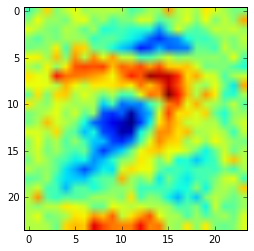

In [112]:
W = best_large_trained_model['weight']
plt.imshow(W[: ,7].reshape(24, 24))

The weights look like the number they are meant to represent, this makes intuitive sense because the pixels are dark where the number should be, and therefore get a postive weight. 

Larger regularization is required for larger data sets as more examples impact the performance. 